## Import
Use elements of the scientific python stack

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

# Import a client
from dask.distributed import Client

# Import intake-esm
import intake

import util

## Setup a PBSCluster
Speed up processing with DASK with 8 threads

In [2]:
cluster = util.get_pbscluster(8)
# Setup your client
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/marsh/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/marsh/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.46:39378,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/marsh/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
print(cluster)
print(client)

PBSCluster(64aa8567, 'tcp://10.12.206.46:39378', workers=0, threads=0, memory=0 B)
<Client: 'tcp://10.12.206.46:39378' processes=0 threads=0, memory=0 B>


## Open a catalog

In [20]:
cat = intake.open_esm_datastore(
    "/glade/work/marsh/intake-esm-catalogs/WACCM6-MA-1deg.json",
    ).search(
    variable=('Uzm','Tzm'),
    frequency=('day_1')
)
print(cat.keys())
# cat

dict_keys(['atm.cam.h1.b.e21.BWSSP245.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.001', 'atm.cam.h6.b.e21.BWSSP245.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.001', 'atm.cam.h6.b.e21.BWma1850.f09_g17.release-cesm2.1.3.c20200918', 'atm.cam.h6.b.e21.BWmaCO2x4.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.001', 'atm.cam.h6.b.e21.BWmaHIST.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.001', 'atm.cam.h6.b.e21.BWmaHIST.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.002', 'atm.cam.h6.b.e21.BWmaHIST.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.003'])


In [4]:
cat = intake.open_esm_datastore(
    "/glade/work/marsh/intake-esm-catalogs/WACCM6-TSMLT-1deg-001.json",
    ).search(
    variable=('U','T'),
    frequency=('day_1')
)
print(cat.keys())
# cat

dict_keys(['atm.cam.h1.b.e21.BWHIST.f09_g17.CMIP6-historical-WACCM.001'])


In [21]:
dsets = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time': 365}, 'decode_times': False})
dsets.keys()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.stream.case'


dict_keys(['atm.cam.h6.b.e21.BWma1850.f09_g17.release-cesm2.1.3.c20200918', 'atm.cam.h6.b.e21.BWmaHIST.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.002', 'atm.cam.h6.b.e21.BWSSP245.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.001', 'atm.cam.h6.b.e21.BWmaCO2x4.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.001', 'atm.cam.h6.b.e21.BWmaHIST.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.001', 'atm.cam.h1.b.e21.BWSSP245.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.001', 'atm.cam.h6.b.e21.BWmaHIST.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.003'])

In [22]:
hist_cases = [key for key in list(cat) if "HIST" in key]
print(len(hist_cases))
print(hist_cases)

3
['atm.cam.h6.b.e21.BWmaHIST.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.002', 'atm.cam.h6.b.e21.BWmaHIST.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.001', 'atm.cam.h6.b.e21.BWmaHIST.f09_g17.release-cesm2.1.3.WACCM-MA-1deg.003']


In [23]:
def read_merra():
    merra = pd.read_csv('merra2_60NS_10hPa.txt', delim_whitespace=True, skiprows=(0,2,3,4,5), parse_dates=True)
    ds = merra.to_xarray()
    ds = ds.rename({'index':'date'})
    ds['U_60N'].attrs['units']='m/s'
    ds['U_60N'].attrs['long_name']='zonal mean zonal wind 60N 10hPa'
    ds['U_60S'].attrs['units']='m/s'
    ds['U_60S'].attrs['long_name']='zonal mean zonal wind 60S 10hPa'

    ds.attrs['source']='MERRA-2'
    
    return ds

In [24]:
ds = dsets[hist_cases[0]]
ds = xr.decode_cf(ds)
ds = ds.sortby('time')

In [25]:
ds

<xarray.Dataset>
Dimensions:       (ilev: 71, lat: 192, lev: 70, lon: 288, nbnd: 2, time: 60226, zlon: 1)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * zlon          (zlon) float64 0.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev           (lev) float64 5.96e-06 9.827e-06 1.62e-05 ... 976.3 992.6
  * ilev          (ilev) float64 4.5e-06 7.42e-06 1.223e-05 ... 985.1 1e+03
  * time          (time) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: nbnd
Data variables: (12/27)
    zlon_bnds     (zlon, nbnd) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    gw            (lat) float64 dask.array<chunksize=(192,), meta=np.ndarray>
    hyam          (lev) float64 dask.array<chunksize=(70,), meta=np.ndarray>
    hybm          (lev) float64 dask.array<chunksize=(70,), meta=np.ndarray>
    P0            float64 ...
    hyai          (ilev) float64 dask.array<chunksize=(71,), meta=np.ndarray>
    ...            ...
    n2ovmr        (time) float64 dask.array<chunksize=(365,), meta=np.ndarray>
    f11vmr        (time) float64 dask.array<chunksize=(365,), meta=np.ndarray>
    f12vmr        (time) float64 dask.array<chunksize=(365,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(365,), meta=np.ndarray>
    nsteph        (time) float64 dask.array<chunksize=(365,), meta=np.ndarray>
    Uzm           (time, ilev, lat, zlon) float32 dask.array<chunksize=(365, 71, 192, 1), meta=np.ndarray>
Attributes:
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    case:                    b.e21.BWmaHIST.f09_g17.release-cesm2.1.3.WACCM-M...
    source:                  CAM
    Conventions:             CF-1.0
    host:                    r6i6n31
    topography_file:         /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv...
    initial_file:            b.e21.BWma1850.f09_g17.release-cesm2.1.3.c202009...
    time_period_freq:        day_1
    intake_esm_varname:      ['Uzm']
    logname:                 mmills
    intake_esm_dataset_key:  atm.cam.h6.b.e21.BWmaHIST.f09_g17.release-cesm2....

In [26]:
var = 'Uzm'

if (var == 'Uzm') or (var == 'Tzm'):
    u60n = ds[var]\
        .sel(time=slice("1979-01", "2015-01"))\
        .sel(lat=60.0, method='nearest')\
        .sel(ilev=10.0, method='nearest')\
        .isel(zlon=0)\
        .compute()
else:
    u60n = ds[var]\
        .sel(time=slice("1979-01", "2015-01"))\
        .sel(lat=60.0, method='nearest')\
        .sel(lev=10.0, method='nearest')\
        .mean(dim='lon')\
        .compute()

u0 = u60n.roll(time=182, roll_coords=False)

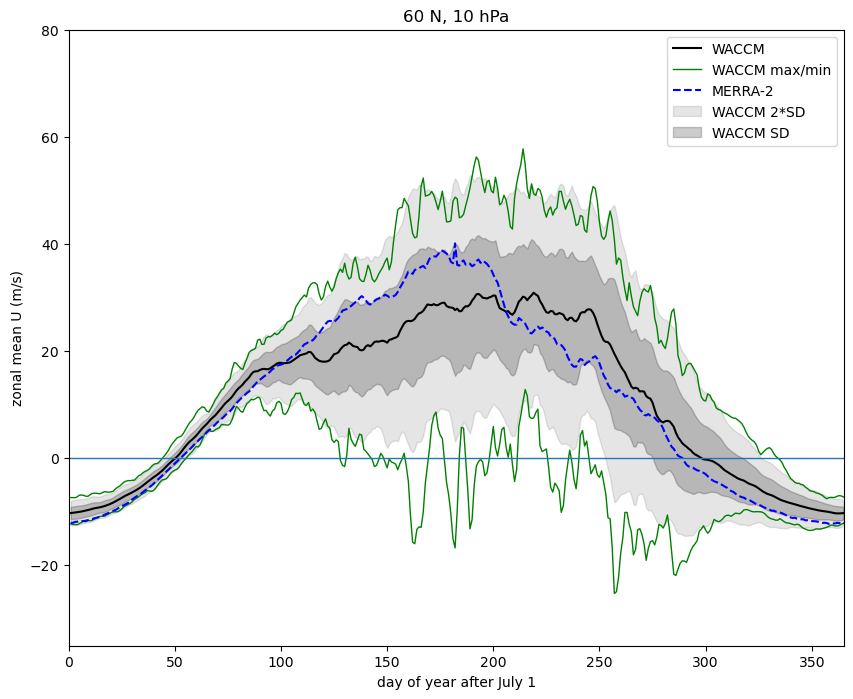

In [27]:
plt.figure(figsize=(10,8))

ubar = u0.groupby('time.dayofyear').mean('time')
usd = u0.groupby('time.dayofyear').std('time')

ubar.plot(color='k', label='WACCM')

plt.fill_between(ubar['dayofyear'], ubar-2*usd, ubar+2*usd, color='k', alpha=0.1, label='WACCM 2*SD')
plt.fill_between(ubar['dayofyear'], ubar-usd, ubar+usd, color='k', alpha=0.2, label='WACCM SD')

np.amin(u0.groupby('time.dayofyear')).plot(color='g', linewidth=1, label='WACCM max/min')
np.amax(u0.groupby('time.dayofyear')).plot(color='g', linewidth=1)

merra = xr.open_dataset('merra_60N_10hPa.nc')
merra_annual = merra['U'].sel(date=slice("1979-01", "2015-01")).groupby('date.dayofyear').mean('date')
merra_annual.roll(dayofyear=182, roll_coords=False).plot(color='b',linestyle='--', label='MERRA-2')

ax = plt.gca()
ax.set_ylabel('zonal mean U (m/s)')
ax.set_ylim((-35,80))
ax.set_xlabel('day of year after July 1')
ax.set_xlim((0,365))

plt.axhline(y=0, linewidth=1)

plt.title('60 N, 10 hPa')
plt.legend()

plt.savefig('u60n.png')
plt.show()

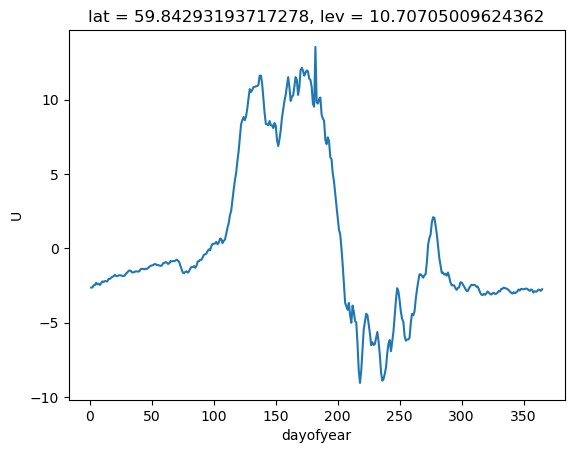

In [19]:
u2 = u0.groupby('time.dayofyear').mean('time')
m2 = merra_annual.roll(dayofyear=182, roll_coords=False)
(m2-u2).plot()

plt.show()


In [13]:
u60s = ds['U']\
    .sel(time=slice("1979-01", "2015-01"))\
    .sel(lat=-60.0, method='nearest')\
    .sel(lev=10.0, method='nearest')\
    .mean(dim='lon')\
    .compute()

In [28]:
u60s = ds['Uzm']\
    .sel(time=slice("1979-01", "2015-01"))\
    .sel(lat=-60.0, method='nearest')\
    .sel(ilev=10.0, method='nearest')\
    .isel(zlon=0)\
    .compute()


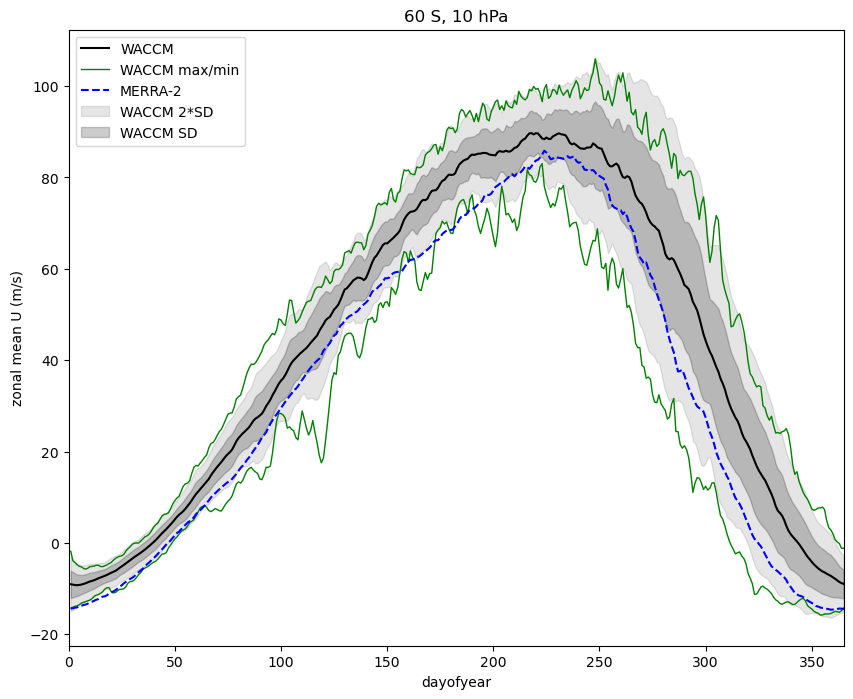

In [29]:
plt.figure(figsize=(10,8))

ubar = u60s.groupby('time.dayofyear').mean('time')
usd = u60s.groupby('time.dayofyear').std('time')

ubar.plot(color='k', label='WACCM')

plt.fill_between(ubar['dayofyear'], ubar-2*usd, ubar+2*usd, color='k', alpha=0.1, label='WACCM 2*SD')
plt.fill_between(ubar['dayofyear'], ubar-usd, ubar+usd, color='k', alpha=0.2, label='WACCM SD')

np.amin(u60s.groupby('time.dayofyear')).plot(color='g', linewidth=1, label='WACCM max/min')
np.amax(u60s.groupby('time.dayofyear')).plot(color='g', linewidth=1)

merra = read_merra()
merra['U_60S'].sel(date=slice("1979-01", "2015-01")).groupby('date.dayofyear').mean('date').plot(color='b',linestyle='--', label='MERRA-2')

ax = plt.gca()
ax.set_ylabel('zonal mean U (m/s)')
ax.set_xlim((0,365))

plt.title('60 S, 10 hPa')
plt.legend()

plt.savefig('u60s.png')
plt.show()

In [ ]:
doy = ubar['dayofyear'].values
doy2 = np.mod((doy+180),365)

In [ ]:
print(merra['date.dayofyear'].values[0:1000])

In [ ]:
t90n = ds['Tzm']\
    .sel(time=slice("1979-01", "2015-01"))\
    .sel(lat=90.0, method='nearest')\
    .sel(ilev=50.0, method='nearest')\
    .isel(zlon=0)\
    .compute()

t0 = t90n.roll(time=182, roll_coords=False)